code for creating a Kernel based relu-RNN learning for sequential MNIST
adapted from : Roth, Christopher, Ingmar Kanitscheider, and Ila Fiete. 2018. “Kernel RNN Learning (KeRNL),” September. https://openreview.net/forum?id=ryGfnoC5KQ.

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import hashlib
import numbers
import matplotlib.cm as cm
from sys import getsizeof
from datetime import datetime
from pathlib import Path
import os

from pandas import DataFrame
from IPython.display import HTML




from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim

## user defined modules 
# kernel rnn cell 
import keRNL_cell 

In [2]:
# uplading mnist data 

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [99]:
# Training Parameters
learning_rate = 1e-6
training_steps = 5000
batch_size = 100
display_step = 10
test_len=128
grad_clip=100
# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
timesteps = 28*28 # timesteps
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)
perturbation_std=1e-3
# tf Graph input


In [100]:
def kernel_RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    with tf.variable_scope('recurrent',initializer=tf.initializers.identity()) as scope: 
        # Define a lstm cell with tensorflow
        keRNL = keRNL_cell.KeRNLCell(num_units=num_hidden,
                                     num_inputs=num_input,
                                     time_steps=timesteps,
                                     noise_std=perturbation_std,
                                     sensitivity_initializer=tf.initializers.identity)
        # Get lstm cell output
        kernel_outputs, kernel_states = tf.nn.dynamic_rnn(keRNL , x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(kernel_outputs[:,-1,:], weights['out']) + biases['out'], kernel_states

In [106]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name='output_weight')
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]),name='output_addition')
    }
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    
    
    logits,states = kernel_RNN(X, weights, biases)
    variable_names=[v.name for v in tf.trainable_variables()]
    trainables=tf.trainable_variables()
    # get the index of trainable variables 
    temporal_filter_index=[np.unicode_.find(k.name,'temporal_filter_coeff')>-1 for k in trainables].index(True)
    sensitivity_tensor_index=[np.unicode_.find(k.name,'sensitivity_tensor')>-1 for k in trainables].index(True)    
    kernel_index=[np.unicode_.find(k.name,'kernel')>-1 for k in trainables].index(True)
    bias_index=[np.unicode_.find(k.name,'bias')>-1 for k in trainables].index(True)
    output_weight_index=[np.unicode_.find(k.name,'output_weight')>-1 for k in trainables].index(True)
    output_addition_index=[np.unicode_.find(k.name,'output_addition')>-1 for k in trainables].index(True)
    a=np.asarray([sensitivity_tensor_index,temporal_kernel_index,kernel_index,output_weight_index],dtype=np.int)
    new_trainables= [trainables[k] for k in a ]
    
    # compute loss for predictions. 
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
    prediction = tf.nn.softmax(logits)
    # compute loss for estimating sensitivity tensor and temporal_filter_coeff, 
    # this is a sum of squared error between a the difference of unperturbed and perturbed hidden state, and its estimate using 
    # sensitivity tensor and temporal_filter coeff. 
    loss_state_prediction=tf.losses.mean_squared_error(tf.subtract(states.h_hat, states.h),
                                                      tf.matmul(states.Gamma,trainables[sensitivity_tensor_index]))

    # Define optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    
    # optimize for temporal_filter and sensitivity_tensor
    sensitivity_tensor_update=tf.gradients(xs=trainables[sensitivity_tensor_index],ys=loss_state_prediction)
    temporal_filter_update=tf.gradients(xs=trainables[temporal_filter_index],ys=loss_state_prediction)
    gradient_terms=np.asarray([sensitivity_tensor_index,temporal_filter_index],dtype=np.int)
    new_trainables= [trainables[k] for k in gradient_terms ]
    new_grads_and_vars=list(zip([sensitivity_tensor_update[-1],temporal_filter_update[-1]],new_trainables))
    train_op = optimizer.apply_gradients(new_grads_and_vars)
## compute gradients 

    # manually calculate gradients 
    #1- sensitivity tensor gradient 
    #sensitivity_tensor_update=tf.matmul(tf.transpose(states.delta_sensitivity),states.Gamma)


    #2- temporal kernel coefficient gradient 
    #temporal_kernel_update=tf.reduce_mean(tf.multiply(states.delta_sensitivity,tf.matmul(states.Gamma,tf.transpose(trainables[sensitivity_tensor_index]))),axis=0)
    
    
    #3- gradient for the recurrent weights 
    #grad_cost_to_output=tf.gradients(loss_op,logits, name= 'grad_cost_to_y')
    #error_in_hidden_state=tf.expand_dims(tf.reduce_mean(tf.matmul(grad_cost_to_output[-1],tf.transpose(trainables[output_weight_index])),axis=0),axis=0)
    #weight_update_aux=tf.matmul(trainables[kernel_index],tf.transpose(error_in_hidden_state))
    #total_trace=tf.concat([states.input_trace,states.recurrent_trace],axis=2)
    #weight_update=tf.transpose(tf.reduce_mean(tf.multiply(total_trace,tf.transpose(tf.tile(weight_update_aux,[1,num_hidden]))),axis=0))
    
    #4- gradient for output weight
    #grad_cost_to_output_weight=tf.gradients(loss_op,trainables[output_weight_index], name= 'grad_cost_to_output_weight')
    #grad_cost_to_output_bias=tf.gradients(loss_op,trainables[output_addition_index], name= 'grad_cost_to_output_bias')


    
# zip gradients and vars 
    #gradient_terms=np.asarray([sensitivity_tensor_index,
    #              temporal_kernel_index,
    #              kernel_index,
    #              output_weight_index,
    #              output_addition_index],dtype=np.int)
    #new_trainables= [trainables[k] for k in gradient_terms ]
    #new_grads_and_vars=list(zip([sensitivity_tensor_update,
    #                             temporal_kernel_update,
    #                             weight_update,
    #                             grad_cost_to_output_weight[-1],
    #                             grad_cost_to_output_bias[-1]],new_trainables))

# Apply gradient Clipping to recurrent weights 
    #new_cropped_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else 
    #                            (grad,var) for grad,var in new_grads_and_vars]
# apply gradients 
    #train_op = optimizer.apply_gradients(new_cropped_grads_and_vars)
    
    # TODO 
    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
        # predictions 
        #prediction=tf.nn.softmax(logits)

    # get variables to save to tensorboard 
    tf.summary.histogram('prediction',prediction+1e-8)
    tf.summary.histogram('logits',logits+1e-8)
    tf.summary.histogram('sensitivity_updates',sensitivity_tensor_update[-1]+1e-8)
    tf.summary.histogram('temporal_kernel_updates',temporal_filter_update[-1]+1e-8)
    tf.summary.scalar('loss',loss_op)
    tf.summary.scalar('loss_state_prediction',loss_state_prediction)
    merged_summary_op=tf.summary.merge_all()
    saver = tf.train.Saver()
    

In [102]:
# verify initialization 
with tf.Session(graph=graph) as sess : 
    sess.run(init)
    values,trainable_vars = sess.run([variable_names,new_trainables])
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        #print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 
     

['variable: ', 'output_weight:0']
['variable: ', 0]
['shape: ', (128, 10)]
['variable: ', 'output_addition:0']
['variable: ', 0]
['shape: ', (10,)]
['variable: ', 'recurrent/rnn/ke_rnl_cell/temporal_filter_coeff:0']
['variable: ', -1]
['shape: ', (128,)]
['variable: ', 'recurrent/rnn/ke_rnl_cell/sensitivity_tensor:0']
['variable: ', -1]
['shape: ', (128, 128)]
['variable: ', 'recurrent/rnn/ke_rnl_cell/kernel:0']
['variable: ', -1]
['shape: ', (129, 128)]
['variable: ', 'recurrent/rnn/ke_rnl_cell/bias:0']
['variable: ', -1]
['shape: ', (128,)]


[(<tf.Tensor 'gradients/MatMul_1_grad/MatMul_1:0' shape=(128, 128) dtype=float32>,
  <tf.Variable 'recurrent/rnn/ke_rnl_cell/sensitivity_tensor:0' shape=(128, 128) dtype=float32_ref>),
 (<tf.Tensor 'gradients_1/recurrent/rnn/while/rnn/ke_rnl_cell/Neg/Enter_grad/b_acc_3:0' shape=(128,) dtype=float32>,
  <tf.Variable 'recurrent/rnn/ke_rnl_cell/temporal_filter_coeff:0' shape=(128,) dtype=float32_ref>)]

In [103]:
log_dir = "logs/kernel_rnn/state_prediction_gc_%d_eta_%d_batch_%d_run_%s" %(grad_clip,learning_rate,batch_size, datetime.now().strftime("%Y%m%d_%H%M"))
Path(log_dir).mkdir(exist_ok=True, parents=True)
filelist = [ f for f in os.listdir(log_dir) if f.endswith(".local") ]
for f in filelist:
    os.remove(os.path.join(log_dir, f))

loop for optimizing sensitivity kernel and temporal filter 

In [109]:
# write graph into tensorboard 
tb_writer = tf.summary.FileWriter(log_dir,graph)
# run a training session 
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for step in range(1,100):#range(1,training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x=batch_x.reshape((batch_size,timesteps,num_input))
        # run optimizaer 
        opt, loss_train, loss_state=sess.run([train_op,loss_op,loss_state_prediction],feed_dict={X:batch_x, Y:batch_y})
        merged_summary=sess.run(merged_summary_op,feed_dict={X:batch_x, Y:batch_y})
        tb_writer.add_summary(merged_summary, global_step=step)

        if step % display_step==0 or step==1 : 
            # get batch loss and accuracy 
            print('Step: {}, state Loss: {:.3f}'.format(
            step + 1, loss_state))

    print("Optimization Finished!")
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", 
        sess.run(loss_state_prediction, feed_dict={X: test_data, Y: test_label}))
    save_path = saver.save(sess, log_dir+"/model.ckpt", global_step=step,write_meta_graph=True)
    print("Model saved in path: %s" % save_path)

Step: 2, state Loss: 37.925
Step: 11, state Loss: 37.970
Step: 21, state Loss: 38.461
Step: 31, state Loss: 37.373
Step: 41, state Loss: 37.937
Step: 51, state Loss: 36.354
Step: 61, state Loss: 36.356
Step: 71, state Loss: 35.600
Step: 81, state Loss: 34.835
Step: 91, state Loss: 34.962
Optimization Finished!
Testing Accuracy: 35.178314
Model saved in path: logs/kernel_rnn/state_prediction_gc_100_eta_0_batch_100_run_20190127_2107/model.ckpt-99


build a new graph that integrates learning of other weights 


In [ ]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name='output_weight')
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]),name='output_addition')
    }
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    
    
    logits,states = kernel_RNN(X, weights, biases)
    variable_names=[v.name for v in tf.trainable_variables()]
    trainables=tf.trainable_variables()
    # get the index of trainable variables 
    temporal_filter_index=[np.unicode_.find(k.name,'temporal_filter_coeff')>-1 for k in trainables].index(True)
    sensitivity_tensor_index=[np.unicode_.find(k.name,'sensitivity_tensor')>-1 for k in trainables].index(True)    
    kernel_index=[np.unicode_.find(k.name,'kernel')>-1 for k in trainables].index(True)
    bias_index=[np.unicode_.find(k.name,'bias')>-1 for k in trainables].index(True)
    output_weight_index=[np.unicode_.find(k.name,'output_weight')>-1 for k in trainables].index(True)
    output_addition_index=[np.unicode_.find(k.name,'output_addition')>-1 for k in trainables].index(True)
    a=np.asarray([sensitivity_tensor_index,temporal_kernel_index,kernel_index,output_weight_index],dtype=np.int)
    new_trainables= [trainables[k] for k in a ]
    
    # compute loss for predictions. 
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
    prediction = tf.nn.softmax(logits)
    # compute loss for estimating sensitivity tensor and temporal_filter_coeff, 
    # this is a sum of squared error between a the difference of unperturbed and perturbed hidden state, and its estimate using 
    # sensitivity tensor and temporal_filter coeff. 
    loss_state_prediction=tf.losses.mean_squared_error(tf.subtract(states.h_hat, states.h),
                                                      tf.matmul(states.Gamma,trainables[sensitivity_tensor_index]))

    # Define optimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    
    # optimize for temporal_filter and sensitivity_tensor
    sensitivity_tensor_update=tf.gradients(xs=trainables[sensitivity_tensor_index],ys=loss_state_prediction)
    temporal_filter_update=tf.gradients(xs=trainables[temporal_filter_index],ys=loss_state_prediction)
    gradient_terms=np.asarray([sensitivity_tensor_index,temporal_filter_index],dtype=np.int)
    new_trainables= [trainables[k] for k in gradient_terms ]
    new_grads_and_vars=list(zip([sensitivity_tensor_update[-1],temporal_filter_update[-1]],new_trainables))
    train_op = optimizer.apply_gradients(new_grads_and_vars)
## compute gradients 

    # manually calculate gradients 
    #1- sensitivity tensor gradient 
    #sensitivity_tensor_update=tf.matmul(tf.transpose(states.delta_sensitivity),states.Gamma)


    #2- temporal kernel coefficient gradient 
    #temporal_kernel_update=tf.reduce_mean(tf.multiply(states.delta_sensitivity,tf.matmul(states.Gamma,tf.transpose(trainables[sensitivity_tensor_index]))),axis=0)
    
    
    #3- gradient for the recurrent weights 
    #grad_cost_to_output=tf.gradients(loss_op,logits, name= 'grad_cost_to_y')
    #error_in_hidden_state=tf.expand_dims(tf.reduce_mean(tf.matmul(grad_cost_to_output[-1],tf.transpose(trainables[output_weight_index])),axis=0),axis=0)
    #weight_update_aux=tf.matmul(trainables[kernel_index],tf.transpose(error_in_hidden_state))
    #total_trace=tf.concat([states.input_trace,states.recurrent_trace],axis=2)
    #weight_update=tf.transpose(tf.reduce_mean(tf.multiply(total_trace,tf.transpose(tf.tile(weight_update_aux,[1,num_hidden]))),axis=0))
    
    #4- gradient for output weight
    #grad_cost_to_output_weight=tf.gradients(loss_op,trainables[output_weight_index], name= 'grad_cost_to_output_weight')
    #grad_cost_to_output_bias=tf.gradients(loss_op,trainables[output_addition_index], name= 'grad_cost_to_output_bias')


    
# zip gradients and vars 
    #gradient_terms=np.asarray([sensitivity_tensor_index,
    #              temporal_kernel_index,
    #              kernel_index,
    #              output_weight_index,
    #              output_addition_index],dtype=np.int)
    #new_trainables= [trainables[k] for k in gradient_terms ]
    #new_grads_and_vars=list(zip([sensitivity_tensor_update,
    #                             temporal_kernel_update,
    #                             weight_update,
    #                             grad_cost_to_output_weight[-1],
    #                             grad_cost_to_output_bias[-1]],new_trainables))

# Apply gradient Clipping to recurrent weights 
    #new_cropped_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else 
    #                            (grad,var) for grad,var in new_grads_and_vars]
# apply gradients 
    #train_op = optimizer.apply_gradients(new_cropped_grads_and_vars)
    
    # TODO 
    # Evaluate model (with test logits, for dropout to be disabled)
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
        # predictions 
        #prediction=tf.nn.softmax(logits)

    # get variables to save to tensorboard 
    tf.summary.histogram('prediction',prediction+1e-8)
    tf.summary.histogram('logits',logits+1e-8)
    tf.summary.histogram('sensitivity_updates',sensitivity_tensor_update[-1]+1e-8)
    tf.summary.histogram('temporal_kernel_updates',temporal_filter_update[-1]+1e-8)
    tf.summary.scalar('loss',loss_op)
    tf.summary.scalar('loss_state_prediction',loss_state_prediction)
    merged_summary_op=tf.summary.merge_all()
    saver = tf.train.Saver()

In [ ]:
# write graph into tensorboard 
tb_writer = tf.summary.FileWriter(log_dir,graph)
# run a training session 
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for step in range(1,100):#range(1,training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x=batch_x.reshape((batch_size,timesteps,num_input))
        # run optimizaer 
        opt, loss_train,acc_train=sess.run([train_op,loss_op,accuracy],feed_dict={X:batch_x, Y:batch_y})
        logits_out, states_out,sensitivity_tensor= sess.run([logits, states,sensitivity_tensor_update],feed_dict={X:batch_x, Y:batch_y})
        merged_summary=sess.run(merged_summary_op,feed_dict={X:batch_x, Y:batch_y})
        tb_writer.add_summary(merged_summary, global_step=step)
        #tb_writer.flush()
        # show interim performance 
        if step % display_step==0 or step==1 : 
            # get batch loss and accuracy 
            print('Step: {}, Train Loss: {:.3f}, Train Acc: {:.3f}'.format(
            step + 1, loss_train, acc_train))
            # write summary 
            #tb_writer.add_summary(acc,global_step=step)
            #tb_writer.flush()
            # evaluate performance on test data 
            test_X=mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
            test_Y=mnist.test.labels[:test_len]

    print("Optimization Finished!")
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", 
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

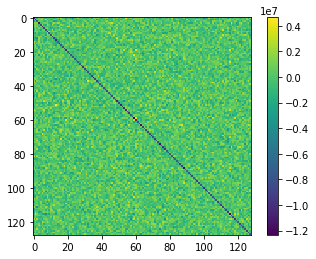

get the name of trainable variables in the graph

In [33]:
sensitivity_tensor

array([[ -9344478.   ,    602806.2  ,    446527.9  , ...,   1137249.8  ,
            11271.383,     60810.793],
       [   902429.3  , -10068336.   ,  -1500424.6  , ...,   1124067.8  ,
         -1903398.5  ,   1539599.4  ],
       [  1074155.1  ,    -42957.336,  -7189409.   , ...,    566068.5  ,
          1538446.2  ,    972819.6  ],
       ...,
       [  1878759.2  ,   1322522.1  ,   -302976.8  , ...,  -8326943.   ,
         -1359860.5  ,  -2843275.   ],
       [ -1063846.8  ,   -171406.39 ,    460706.78 , ...,   -327648.34 ,
         -9861845.   ,    -75493.47 ],
       [  -387237.22 ,   1417995.8  ,    411078.7  , ...,   -554274.   ,
           645293.6  ,  -7525199.5  ]], dtype=float32)